In [1]:
#Keras Package
import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, Flatten, LSTM, Embedding, Reshape, GRU, Input, RNN
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, Adam
from keras.utils import np_utils, plot_model
from keras.callbacks import EarlyStopping
#Numpy
import numpy as np
#Load Data
import h5py, glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, train_test_split
#Visualization
import matplotlib.pyplot as plt
#Timing
from time import time

C:\Users\Nabeel\Anaconda3\envs\env_full\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#Import data
def import_data(filename):
    #Removes nan trial from imported data
    def remove_nan(X):
        idx = 0
        idx_nan = []
        for trial in X:
            if (np.isnan(trial).any()):
                print('Trial %d has nan' % idx)
                idx_nan.append(idx)
            idx += 1
        return np.delete(X,idx_nan,0), np.delete(y,idx_nan,0)

    #Load data
    A01T = h5py.File(filename, 'r')
    X = np.copy(A01T['image'])
    X = X[:,0:22,:] #remove EOG lines

    #769-left hand; 770-right hand; 771-both feet; 772-tongue
    y = np.copy(A01T['type'])
    y = y[0,0:X.shape[0]:1]
    y = np.asarray(y, dtype=np.int32)
    
    #Data Preprocess
    X, y = remove_nan(X) #Remove nans
    X = np.transpose(X,(0,2,1))
    X = np.expand_dims(X,3) #Expand dimension

    #Convert y to one-hot label
    encoder = LabelEncoder()
    encoder.fit(y)
    encoded_y = encoder.transform(y)
    y = np_utils.to_categorical(encoded_y)
    num_classes = y.shape[1]

    #Check whole dimensions
    print(X.shape)
    print(y.shape)
    
    return X, y, num_classes

In [3]:
#Load files
files = glob.glob('project_datasets/*.mat')
subjects = -1
X = {}
y = {}
for file in files:
    subjects += 1
    print(subjects)
    X[str(subjects)], y[str(subjects)], num_classes = import_data(file)    

0
Trial 56 has nan
(287, 1000, 22, 1)
(287, 4)
1
Trial 237 has nan
Trial 284 has nan
(286, 1000, 22, 1)
(286, 4)
2
Trial 113 has nan
Trial 249 has nan
(286, 1000, 22, 1)
(286, 4)
3
Trial 144 has nan
Trial 145 has nan
Trial 146 has nan
Trial 179 has nan
(284, 1000, 22, 1)
(284, 4)
4
Trial 6 has nan
Trial 28 has nan
Trial 57 has nan
Trial 101 has nan
Trial 220 has nan
Trial 225 has nan
(282, 1000, 22, 1)
(282, 4)
5
Trial 97 has nan
Trial 115 has nan
Trial 140 has nan
(285, 1000, 22, 1)
(285, 4)
6
(288, 1000, 22, 1)
(288, 4)
7
Trial 58 has nan
Trial 81 has nan
Trial 124 has nan
Trial 151 has nan
Trial 178 has nan
Trial 275 has nan
(282, 1000, 22, 1)
(282, 4)
8
Trial 22 has nan
Trial 61 has nan
Trial 92 has nan
Trial 93 has nan
Trial 159 has nan
Trial 202 has nan
Trial 204 has nan
Trial 218 has nan
Trial 239 has nan
Trial 250 has nan
(278, 1000, 22, 1)
(278, 4)


In [4]:
#Concatenate all data
t0 = time()
X_net = X[str(0)];
y_net = y[str(0)];
for i in np.arange(1,len(X)):
    X_net = np.concatenate((X_net,X[str(i)]),axis=0)
    y_net = np.concatenate((y_net,y[str(i)]),axis=0)
t1 = time()
total = t1 - t0
print("Time to concatenate = %f" % total)
print()

Time to concatenate = 0.755008



In [5]:
#Creating Validation and Testing data
X_train, X_test, y_train, y_test = train_test_split(X_net, y_net, test_size = 5/100, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 5/95, random_state=0)
print(X_net.shape)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print()
print(y_net.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(2558, 1000, 22, 1)
(2302, 1000, 22, 1)
(128, 1000, 22, 1)
(128, 1000, 22, 1)

(2558, 4)
(2302, 4)
(128, 4)
(128, 4)


In [6]:
#Create C-RNN
def RNN():
    activation = 'elu'
    init = 'glorot_uniform'
    model = Sequential()

    #Block 1
    model.add(Conv2D(filters = 25, kernel_size = (10,1), kernel_initializer=init, input_shape=X_train[0].shape))
    model.add(Conv2D(filters = 25, kernel_size = (1, 22), kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(3, 1), strides=3))
    model.add(Dropout(0.5))

    #Block 2
    model.add(Conv2D(filters = 50, kernel_size = (10, 1), kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(3, 1), strides=3))
    model.add(Dropout(0.5))

    #Block 3
    model.add(Conv2D(filters = 100, kernel_size = (10, 1), kernel_initializer = init))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(3, 1), strides=3))
    model.add(Dropout(0.5))

    #Block 4
    model.add(Conv2D(filters = 200, kernel_size = (10, 1), kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(3, 1), strides=3))
    model.add(Dropout(0.5))
    
    #RNN Block
    model.add(Reshape((-1, 200)))
    model.add(GRU(200,return_sequences=True,dropout=0.1))
    model.add(GRU(200,return_sequences=True,dropout=0.1))
    model.add(GRU(200,return_sequences=True,dropout=0.1))
    model.add(GRU(200,dropout=0.1))
    
    #model.add(Flatten())
    model.add(Dense(units=4, kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(Activation('softmax'))
    
    return model

In [7]:
# #Concatenate all data
# t0 = time()
# X_net = X[str(0)];
# y_net = y[str(0)];
# for i in np.arange(1,len(X)):
#     X_net = np.concatenate((X_net,X[str(i)]),axis=0)
#     y_net = np.concatenate((y_net,y[str(i)]),axis=0)
# t1 = time()
# total = t1 - t0
# print("Time to concatenate = %f" % total)
# print()

In [8]:
# Train RNN
batch_size = 16
epochs = 100
opt = keras.optimizers.adam(lr=0.001)

RNN = RNN()
RNN.compile(loss='categorical_crossentropy',
             optimizer=opt,
             metrics=['accuracy'])

t0 = time()
history = RNN.fit(X_train, y_train,
                   batch_size=batch_size,
                   validation_data=(X_val, y_val),
                   epochs=epochs)

t1 = time()

Train on 2302 samples, validate on 128 samples
Epoch 1/100
2302/2302 [==============================] - 8s 4ms/step - loss: 1.4037 - acc: 0.2858 - val_loss: 1.4041 - val_acc: 0.2578
Epoch 2/100
2302/2302 [==============================] - 6s 2ms/step - loss: 1.3392 - acc: 0.3553 - val_loss: 1.3069 - val_acc: 0.3828
Epoch 3/100
2302/2302 [==============================] - 5s 2ms/step - loss: 1.3047 - acc: 0.3775 - val_loss: 1.3084 - val_acc: 0.3594
Epoch 4/100
2302/2302 [==============================] - 5s 2ms/step - loss: 1.2747 - acc: 0.4053 - val_loss: 1.2865 - val_acc: 0.3984
Epoch 5/100
2302/2302 [==============================] - 5s 2ms/step - loss: 1.2428 - acc: 0.4305 - val_loss: 1.1626 - val_acc: 0.4766
Epoch 6/100
2302/2302 [==============================] - 6s 2ms/step - loss: 1.2422 - acc: 0.4366 - val_loss: 1.2026 - val_acc: 0.4062
Epoch 7/100
2302/2302 [==============================] - 6s 2ms/step - loss: 1.2125 - acc: 0.4461 - val_loss: 1.3123 - val_acc: 0.3984
Epoch 8/

Epoch 61/100
2302/2302 [==============================] - 5s 2ms/step - loss: 0.6295 - acc: 0.7741 - val_loss: 0.9416 - val_acc: 0.6406
Epoch 62/100
2302/2302 [==============================] - 5s 2ms/step - loss: 0.5994 - acc: 0.7863 - val_loss: 0.9191 - val_acc: 0.6250
Epoch 63/100
2302/2302 [==============================] - 5s 2ms/step - loss: 0.6054 - acc: 0.7806 - val_loss: 0.9377 - val_acc: 0.6406
Epoch 64/100
2302/2302 [==============================] - 5s 2ms/step - loss: 0.6318 - acc: 0.7615 - val_loss: 0.9163 - val_acc: 0.7109
Epoch 65/100
2302/2302 [==============================] - 5s 2ms/step - loss: 0.6088 - acc: 0.7806 - val_loss: 0.8985 - val_acc: 0.6406
Epoch 66/100
2302/2302 [==============================] - 5s 2ms/step - loss: 0.5932 - acc: 0.7876 - val_loss: 0.9714 - val_acc: 0.6562
Epoch 67/100
2302/2302 [==============================] - 5s 2ms/step - loss: 0.5983 - acc: 0.7758 - val_loss: 0.9156 - val_acc: 0.6562
Epoch 68/100
2302/2302 [========================

Time to train = 543.916458


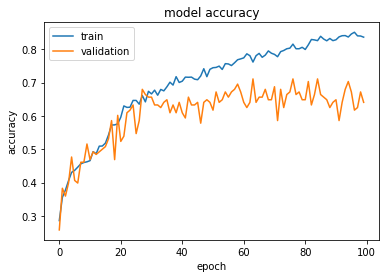

In [9]:
# Plot Results
total = t1 - t0
print("Time to train = %f" % total)

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [10]:
# Testing Accuracy
test_results = RNN.predict(x=X_test, batch_size=batch_size)
categ_results = np.argmax(test_results,axis=1)
categ_test = np.argmax(y_test,axis=1)
test_acc = np.sum(categ_results==categ_test)/len(categ_results)
print('Training Accuracy: %.3f' % history.history['acc'][-1])
print('Validation Accuracy: %.3f' % history.history['val_acc'][-1])
print('Testing Accuracy: %.3f' % test_acc)

Training Accuracy: 0.836
Validation Accuracy: 0.641
Testing Accuracy: 0.688
